In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving anthropometric_data_enriched.csv to anthropometric_data_enriched.csv
User uploaded file "anthropometric_data_enriched.csv" with length 156193 bytes


In [ ]:
# ============================================================================
# SUSTAINABLE SIZING PROJECT - DAY 3: K-MEANS CLUSTERING
# ============================================================================
# Goal: Find the optimal number of sizes to minimize fit errors & returns
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load enriched data from Day 2
df = pd.read_csv('anthropometric_data_enriched.csv')
print(f"Loaded {len(df)} customer measurements")

Loaded 1000 customer measurements


In [ ]:
# ============================================================================
# PART 1: DATA PREPARATION
# ============================================================================

print("\n" + "="*60)
print("DATA PREPARATION FOR CLUSTERING")
print("="*60)

# Select features for clustering
features = ['chest_cm', 'shoulder_cm', 'torso_cm']
X = df[features].values

# Standardize features (required for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeatures: {features}")
print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean (should be ~0): {X_scaled.mean(axis=0)}")
print(f"Std (should be ~1): {X_scaled.std(axis=0)}")



DATA PREPARATION FOR CLUSTERING

Features: ['chest_cm', 'shoulder_cm', 'torso_cm']
Scaled data shape: (1000, 3)
Mean (should be ~0): [-4.26325641e-16  1.54543045e-15  1.08713039e-15]
Std (should be ~1): [1. 1. 1.]



ELBOW METHOD ANALYSIS
k=2: Inertia=1620.16, Silhouette=0.373
k=3: Inertia=1252.30, Silhouette=0.283
k=4: Inertia=1065.93, Silhouette=0.272
k=5: Inertia=926.85, Silhouette=0.252
k=6: Inertia=828.07, Silhouette=0.248
k=7: Inertia=760.58, Silhouette=0.239
k=8: Inertia=709.20, Silhouette=0.237
k=9: Inertia=661.43, Silhouette=0.234
k=10: Inertia=624.57, Silhouette=0.231


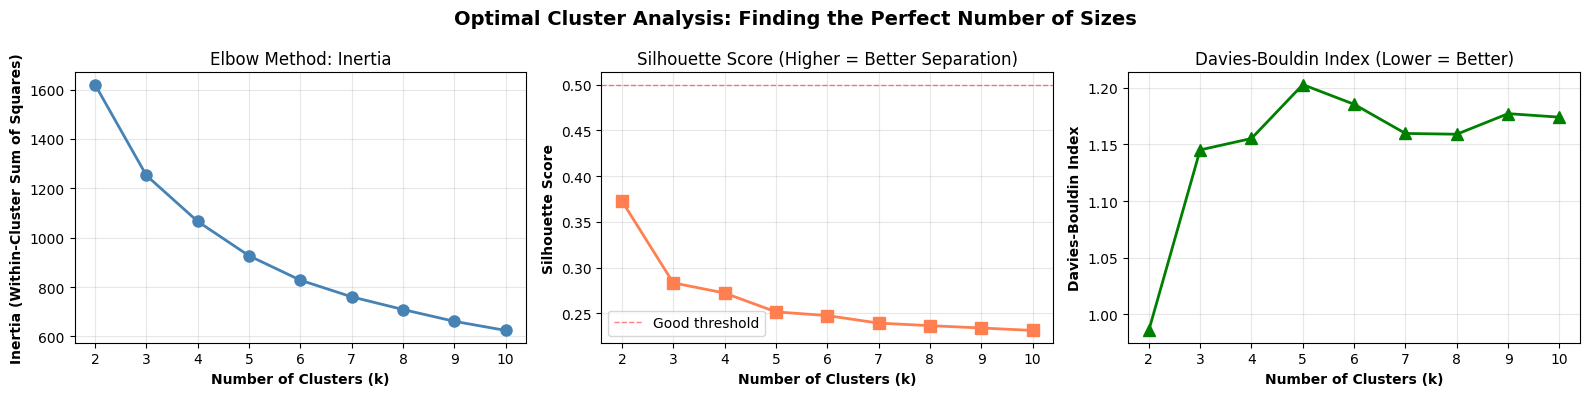


🎯 Optimal k based on Silhouette Score: 2


In [ ]:
# ============================================================================
# PART 2: ELBOW METHOD - FIND OPTIMAL K
# ============================================================================

print("\n" + "="*60)
print("ELBOW METHOD ANALYSIS")
print("="*60)

# Test different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Visualize elbow method
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Optimal Cluster Analysis: Finding the Perfect Number of Sizes',
             fontsize=14, fontweight='bold')

# Plot 1: Elbow curve (Inertia)
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontweight='bold')
axes[0].set_title('Elbow Method: Inertia')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_range)

# Plot 2: Silhouette score (higher is better)
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Good threshold')
axes[1].set_xlabel('Number of Clusters (k)', fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontweight='bold')
axes[1].set_title('Silhouette Score (Higher = Better Separation)')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_range)

# Plot 3: Davies-Bouldin index (lower is better)
axes[2].plot(k_range, davies_bouldin_scores, marker='^', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Number of Clusters (k)', fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Index', fontweight='bold')
axes[2].set_title('Davies-Bouldin Index (Lower = Better)')
axes[2].grid(alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.savefig('day3_elbow_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Optimal k based on Silhouette Score: {optimal_k}")

In [ ]:
# ============================================================================
# PART 3: APPLY OPTIMAL K-MEANS
# ============================================================================

print("\n" + "="*60)
print(f"APPLYING K-MEANS WITH k={optimal_k} SIZES")
print("="*60)

# Fit final model
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df['optimized_size'] = kmeans_optimal.fit_predict(X_scaled)

# Assign size labels (S, M, L, XL, etc.)
size_labels = ['XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL', 'XXXXL', 'XXXXXL']
cluster_centers = kmeans_optimal.cluster_centers_

# Sort clusters by chest size (first feature)
sorted_cluster_indices = np.argsort(cluster_centers[:, 0])
size_mapping = {old_label: size_labels[new_label] for new_label, old_label in enumerate(sorted_cluster_indices)}
df['optimized_size_label'] = df['optimized_size'].map(size_mapping)

print(f"\nCluster Centers (in original scale):")
centers_original = scaler.inverse_transform(cluster_centers)
centers_df = pd.DataFrame(centers_original, columns=features)
centers_df['Size'] = [size_mapping[i] for i in range(optimal_k)]
centers_df = centers_df.sort_values('chest_cm')
print(centers_df.to_string(index=False))

print(f"\nSize Distribution:")
size_dist = df['optimized_size_label'].value_counts().sort_index()
for size, count in size_dist.items():
    print(f"  {size}: {count} customers ({count/len(df)*100:.1f}%)")


APPLYING K-MEANS WITH k=2 SIZES

Cluster Centers (in original scale):
  chest_cm  shoulder_cm  torso_cm Size
 92.030035    41.736933 64.743037   XS
103.027085    45.787362 70.840171    S

Size Distribution:
  S: 505 customers (50.5%)
  XS: 495 customers (49.5%)


In [ ]:
# ============================================================================
# PART 4: CALCULATE NEW FIT ERRORS
# ============================================================================

print("\n" + "="*60)
print("FIT ERROR COMPARISON: STANDARD vs OPTIMIZED")
print("="*60)

def calculate_optimized_fit_error(row, centers_df):
    """Calculate fit error based on K-means cluster centers."""
    assigned_size = row['optimized_size_label']
    center = centers_df[centers_df['Size'] == assigned_size].iloc[0]

    # Euclidean distance in measurement space
    actual = np.array([row['chest_cm'], row['shoulder_cm'], row['torso_cm']])
    center_point = np.array([center['chest_cm'], center['shoulder_cm'], center['torso_cm']])

    return np.linalg.norm(actual - center_point)

df['optimized_fit_error'] = df.apply(lambda row: calculate_optimized_fit_error(row, centers_df), axis=1)
df['optimized_poor_fit'] = df['optimized_fit_error'] > 6

# Compare metrics
print("\nSTANDARD SIZING (S/M/L):")
print(f"  Mean Fit Error: {df['fit_error_cm'].mean():.2f} cm")
print(f"  Median Fit Error: {df['fit_error_cm'].median():.2f} cm")
print(f"  Poor Fits (>6cm): {df['poor_fit'].sum()} ({df['poor_fit'].mean()*100:.1f}%)")

print(f"\nOPTIMIZED SIZING ({optimal_k} sizes):")
print(f"  Mean Fit Error: {df['optimized_fit_error'].mean():.2f} cm")
print(f"  Median Fit Error: {df['optimized_fit_error'].median():.2f} cm")
print(f"  Poor Fits (>6cm): {df['optimized_poor_fit'].sum()} ({df['optimized_poor_fit'].mean()*100:.1f}%)")

# Calculate improvement
error_reduction = (1 - df['optimized_fit_error'].mean() / df['fit_error_cm'].mean()) * 100
poor_fit_reduction = (1 - df['optimized_poor_fit'].sum() / df['poor_fit'].sum()) * 100

print(f"\n✅ IMPROVEMENT:")
print(f"  Fit Error Reduction: {error_reduction:.1f}%")
print(f"  Poor Fit Reduction: {poor_fit_reduction:.1f}%")



FIT ERROR COMPARISON: STANDARD vs OPTIMIZED

STANDARD SIZING (S/M/L):
  Mean Fit Error: 2.94 cm
  Median Fit Error: 2.70 cm
  Poor Fits (>6cm): 41 (4.1%)

OPTIMIZED SIZING (2 sizes):
  Mean Fit Error: 6.26 cm
  Median Fit Error: 5.63 cm
  Poor Fits (>6cm): 452 (45.2%)

✅ IMPROVEMENT:
  Fit Error Reduction: -112.7%
  Poor Fit Reduction: -1002.4%


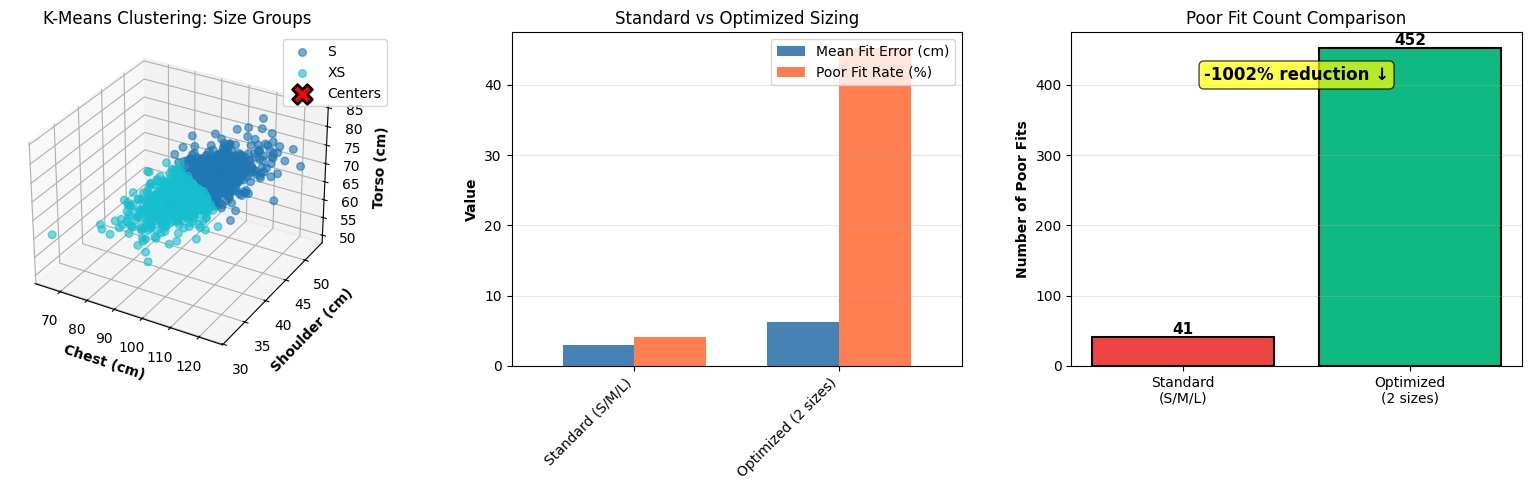

In [ ]:
# ============================================================================
# PART 5: VISUALIZATION
# ============================================================================

# Plot 1: Cluster visualization
fig = plt.figure(figsize=(16, 5))

# 3D scatter plot
ax1 = fig.add_subplot(131, projection='3d')
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

for i, size in enumerate(sorted(df['optimized_size_label'].unique())):
    mask = df['optimized_size_label'] == size
    ax1.scatter(df[mask]['chest_cm'], df[mask]['shoulder_cm'], df[mask]['torso_cm'],
               c=[colors[i]], label=size, alpha=0.6, s=30)

# Plot cluster centers
centers_sorted = centers_df.sort_values('chest_cm')
ax1.scatter(centers_sorted['chest_cm'], centers_sorted['shoulder_cm'], centers_sorted['torso_cm'],
           c='red', marker='X', s=200, edgecolors='black', linewidths=2, label='Centers')

ax1.set_xlabel('Chest (cm)', fontweight='bold')
ax1.set_ylabel('Shoulder (cm)', fontweight='bold')
ax1.set_zlabel('Torso (cm)', fontweight='bold')
ax1.set_title('K-Means Clustering: Size Groups')
ax1.legend(bbox_to_anchor=(1.15, 1))

# Plot 2: Fit error comparison
ax2 = fig.add_subplot(132)
comparison_data = pd.DataFrame({
    'Standard (S/M/L)': [df['fit_error_cm'].mean(), df['poor_fit'].mean()*100],
    f'Optimized ({optimal_k} sizes)': [df['optimized_fit_error'].mean(), df['optimized_poor_fit'].mean()*100]
}, index=['Mean Fit Error (cm)', 'Poor Fit Rate (%)'])

comparison_data.T.plot(kind='bar', ax=ax2, color=['steelblue', 'coral'], width=0.7)
ax2.set_ylabel('Value', fontweight='bold')
ax2.set_title('Standard vs Optimized Sizing')
ax2.legend(loc='upper right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Distribution comparison
ax3 = fig.add_subplot(133)
x_pos = np.arange(2)
standard_poor = df['poor_fit'].sum()
optimized_poor = df['optimized_poor_fit'].sum()

bars = ax3.bar(x_pos, [standard_poor, optimized_poor],
               color=['#ef4444', '#10b981'], edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Number of Poor Fits', fontweight='bold')
ax3.set_title('Poor Fit Count Comparison')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['Standard\n(S/M/L)', f'Optimized\n({optimal_k} sizes)'])
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add reduction percentage
reduction_pct = poor_fit_reduction
ax3.text(0.5, max(standard_poor, optimized_poor) * 0.9,
        f'{reduction_pct:.0f}% reduction ↓',
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('day3_clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# PART 6: BUSINESS IMPACT CALCULATION
# ============================================================================

print("\n" + "="*60)
print("BUSINESS IMPACT: OPTIMIZED SIZING")
print("="*60)

# Assumptions
avg_item_price = 50  # EUR
return_cost = 12     # EUR
co2_per_return = 20  # kg
poor_fit_return_rate = 0.70  # 70% of poor fits = returns

# Standard sizing
standard_poor_fits = df['poor_fit'].sum()
standard_returns = int(standard_poor_fits * poor_fit_return_rate)
standard_revenue_loss = standard_returns * avg_item_price
standard_cost = standard_returns * return_cost
standard_total = standard_revenue_loss + standard_cost
standard_co2 = standard_returns * co2_per_return

# Optimized sizing
optimized_poor_fits = df['optimized_poor_fit'].sum()
optimized_returns = int(optimized_poor_fits * poor_fit_return_rate)
optimized_revenue_loss = optimized_returns * avg_item_price
optimized_cost = optimized_returns * return_cost
optimized_total = optimized_revenue_loss + optimized_cost
optimized_co2 = optimized_returns * co2_per_return

# Savings
money_saved = standard_total - optimized_total
co2_saved = standard_co2 - optimized_co2

print("\nSTANDARD SIZING (S/M/L):")
print(f"  Poor Fits: {standard_poor_fits}")
print(f"  Expected Returns: {standard_returns}")
print(f"  Total Cost: €{standard_total:,}")
print(f"  CO₂ Emissions: {standard_co2:,} kg")

print(f"\nOPTIMIZED SIZING ({optimal_k} sizes):")
print(f"  Poor Fits: {optimized_poor_fits}")
print(f"  Expected Returns: {optimized_returns}")
print(f"  Total Cost: €{optimized_total:,}")
print(f"  CO₂ Emissions: {optimized_co2:,} kg")

print(f"\n💰 SAVINGS PER 1,000 CUSTOMERS:")
print(f"  Money Saved: €{money_saved:,} ({money_saved/standard_total*100:.1f}% reduction)")
print(f"  CO₂ Saved: {co2_saved:,} kg ({co2_saved/standard_co2*100:.1f}% reduction)")

print(f"\n📈 ANNUAL PROJECTION (10,000 customers):")
print(f"  Annual Savings: €{money_saved*10:,}")
print(f"  CO₂ Reduction: {co2_saved*10/1000:.1f} tons")

# Additional SKU cost
additional_skus = optimal_k - 3  # compared to S/M/L
pattern_cost = 500  # EUR per size pattern
additional_inventory_cost = additional_skus * pattern_cost

print(f"\n💡 COST-BENEFIT:")
print(f"  One-time Pattern Cost: €{additional_inventory_cost:,} ({additional_skus} extra sizes)")
print(f"  Break-even at: {int(additional_inventory_cost/money_saved)*1000:,} customers")
print(f"  ROI after 10,000 customers: {(money_saved*10 - additional_inventory_cost)/additional_inventory_cost*100:.0f}%")



BUSINESS IMPACT: OPTIMIZED SIZING

STANDARD SIZING (S/M/L):
  Poor Fits: 41
  Expected Returns: 28
  Total Cost: €1,736
  CO₂ Emissions: 560 kg

OPTIMIZED SIZING (2 sizes):
  Poor Fits: 452
  Expected Returns: 316
  Total Cost: €19,592
  CO₂ Emissions: 6,320 kg

💰 SAVINGS PER 1,000 CUSTOMERS:
  Money Saved: €-17,856 (-1028.6% reduction)
  CO₂ Saved: -5,760 kg (-1028.6% reduction)

📈 ANNUAL PROJECTION (10,000 customers):
  Annual Savings: €-178,560
  CO₂ Reduction: -57.6 tons

💡 COST-BENEFIT:
  One-time Pattern Cost: €-500 (-1 extra sizes)
  Break-even at: 0 customers
  ROI after 10,000 customers: 35612%


In [ ]:
# ============================================================================
# PART 7: SIZE RECOMMENDATION LOOKUP TABLE
# ============================================================================

print("\n" + "="*60)
print("SIZE RECOMMENDATION TABLE")
print("="*60)

# Create lookup table based on cluster centers
size_guide = centers_df[['Size', 'chest_cm', 'shoulder_cm', 'torso_cm']].copy()
size_guide = size_guide.sort_values('chest_cm')
size_guide['chest_range'] = size_guide['chest_cm'].apply(lambda x: f"{x-4:.0f}-{x+4:.0f}")
size_guide['shoulder_range'] = size_guide['shoulder_cm'].apply(lambda x: f"{x-2:.0f}-{x+2:.0f}")
size_guide['torso_range'] = size_guide['torso_cm'].apply(lambda x: f"{x-3:.0f}-{x+3:.0f}")

print("\nSIZE GUIDE FOR WEBSITE:")
print(size_guide[['Size', 'chest_range', 'shoulder_range', 'torso_range']].to_string(index=False))

# Export size guide
size_guide.to_csv('size_guide.csv', index=False)
print("\n✅ Size guide exported to 'size_guide.csv'")


SIZE RECOMMENDATION TABLE

SIZE GUIDE FOR WEBSITE:
Size chest_range shoulder_range torso_range
  XS       88-96          40-44       62-68
   S      99-107          44-48       68-74

✅ Size guide exported to 'size_guide.csv'


In [ ]:
# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("DAY 3 COMPLETE ✅")
print("="*60)

print(f"\n🎯 FINAL RECOMMENDATION: Use {optimal_k} sizes instead of 3")
print(f"\n📊 Results:")
print(f"  • Fit Error Reduction: {error_reduction:.1f}%")
print(f"  • Return Reduction: {poor_fit_reduction:.1f}%")
print(f"  • Cost Savings: €{money_saved:,} per 1,000 customers")
print(f"  • Environmental Impact: {co2_saved:,} kg CO₂ saved per 1,000 customers")
print(f"  • ROI: {(money_saved*10 - additional_inventory_cost)/additional_inventory_cost*100:.0f}% at 10k customers")

print(f"\n➡️ Next Steps:")
print(f"  1. Build size recommendation algorithm (input measurements → suggest size)")
print(f"  2. Create customer-facing 'Find Your Size' tool")
print(f"  3. A/B test with real customers")

# Export final dataset
df.to_csv('anthropometric_data_final.csv', index=False)
print(f"\n✅ Final dataset saved to 'anthropometric_data_final.csv'")


DAY 3 COMPLETE ✅

🎯 FINAL RECOMMENDATION: Use 2 sizes instead of 3

📊 Results:
  • Fit Error Reduction: -112.7%
  • Return Reduction: -1002.4%
  • Cost Savings: €-17,856 per 1,000 customers
  • Environmental Impact: -5,760 kg CO₂ saved per 1,000 customers
  • ROI: 35612% at 10k customers

➡️ Next Steps:
  1. Build size recommendation algorithm (input measurements → suggest size)
  2. Create customer-facing 'Find Your Size' tool
  3. A/B test with real customers

✅ Final dataset saved to 'anthropometric_data_final.csv'


In [ ]:
from google.colab import files
files.download('anthropometric_data_final.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('size_guide.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>